<a href="https://colab.research.google.com/github/niakurniawati00/Customer-Segment-Project/blob/main/Customer_Segmentation_Project_Nia_RFM_Conqueror_2_Project_DS_Batch_45.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [ ]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [ ]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

The data contains 541909 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [ ]:
# Check missing value
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


We could see that there is missing value in `description` and `CustomerID` columns. We could remove those missing values.

In [ ]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
df.shape

(406829, 8)

Then we could do some descriptive statistic.

In [ ]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [ ]:
# Check anomaly data (Ada berapa data yg kurang dari 0 untuk quantity dan sama dengan 0 untuk price)
quantity_zero = len(df[df["Quantity"] <=0])
perc_quanity_zero = (len(df[df["Quantity"] <=0]) / len(df)) * 100
unit_price_zero = len(df[df["UnitPrice"] == 0])
perc_unit_price_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with quantity less or equal than zero")
print("About {:.2f}% of total data".format(perc_quanity_zero))
print("The data consist of", str(unit_price_zero), "rows of data with quantity equal than zero")
print("About {:.2f}% of total data".format(perc_unit_price_zero))

The data consist of 8905 rows of data with quantity less or equal than zero
About 2.19% of total data
The data consist of 40 rows of data with quantity equal than zero
About 0.01% of total data


Then just remove those anomaly data

In [ ]:
# Remove anomaly / outliers
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [ ]:
df[df["Quantity"] == 80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


Now we're good to go. Lets do some data exploration!

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
# Check unique value
df[["InvoiceNo","StockCode", "CustomerID", "Country"]].nunique()

,0
InvoiceNo,18532
StockCode,3665
CustomerID,4338
Country,37


There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

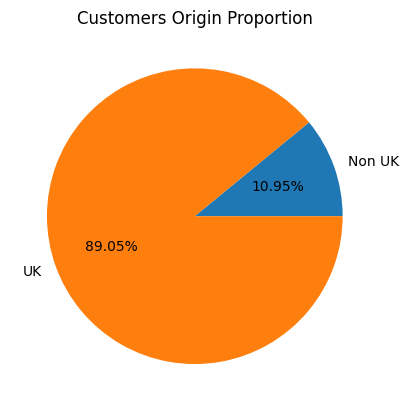

In [ ]:
# Simplify country origin (Pie chart untuk melihat komposisi negara)
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [ ]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

In [ ]:
import matplotlib.dates as mdates

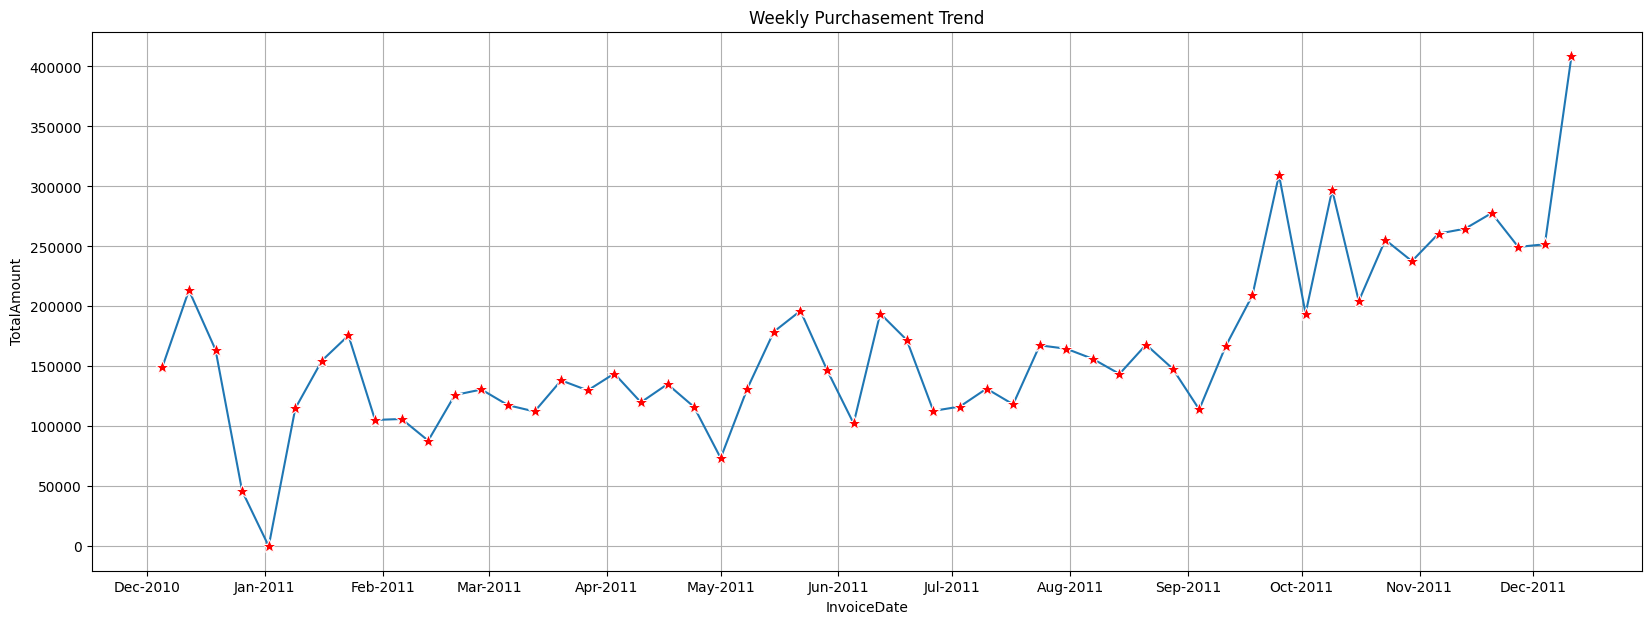

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

<ipython-input-34-5b277a02505f>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()


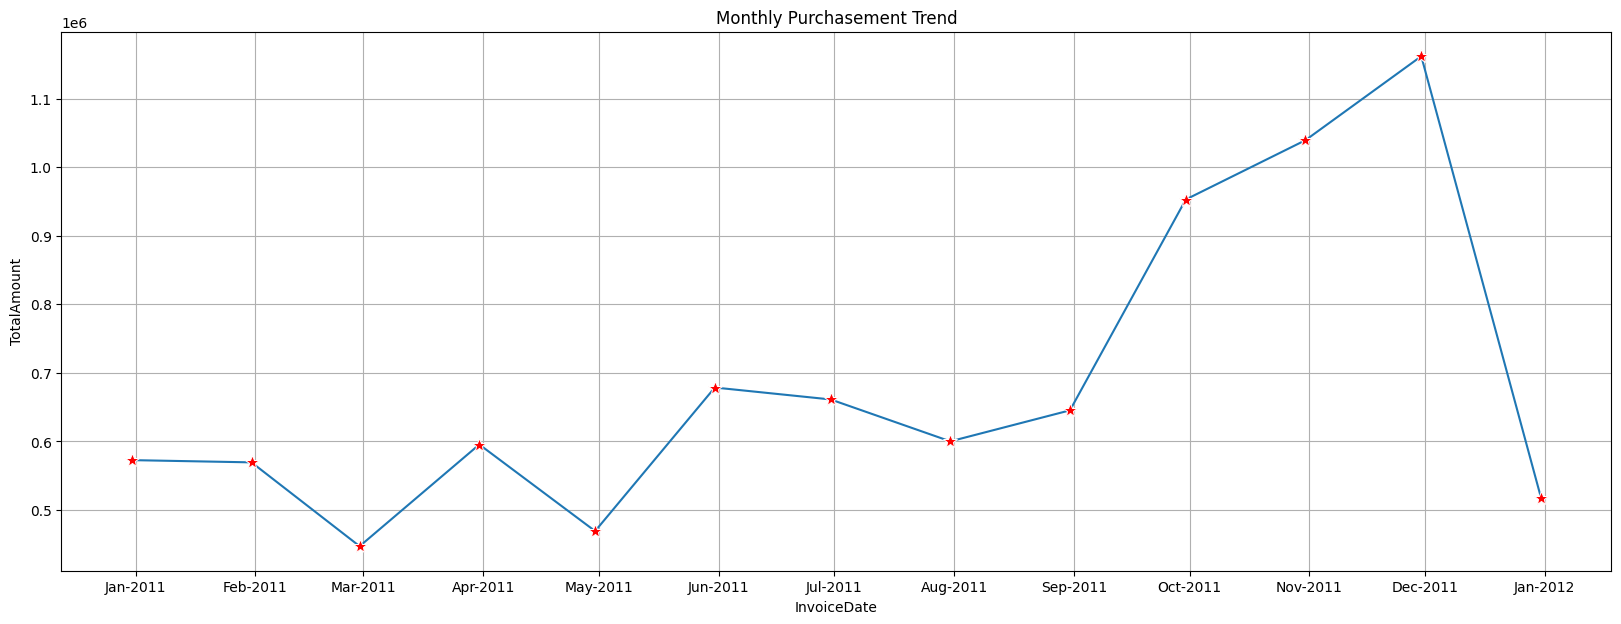

In [ ]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency = df.groupby(["CustomerID"])["InvoiceDate"].max()
recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename("Recency")

recency.head()

,Recency
CustomerID,
12346.0,325
12347.0,1
12348.0,74
12349.0,18
12350.0,309


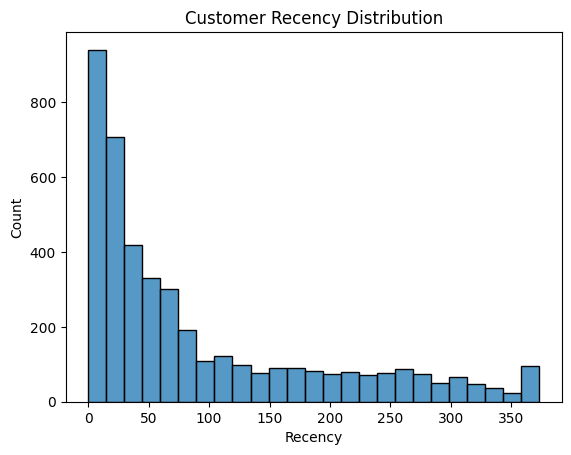

In [ ]:
# Recency histogram plot
plt.title("Customer Recency Distribution")
sns.histplot(recency)
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df.groupby(["CustomerID"])["InvoiceNo"].count()
frequency = frequency.rename("Frequency")

frequency.head()

,Frequency
CustomerID,
12346.0,1
12347.0,182
12348.0,31
12349.0,73
12350.0,17


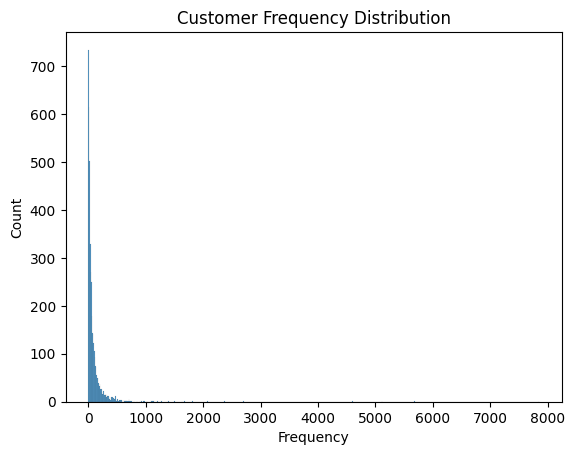

In [ ]:
# Frequency histogram plot
plt.title("Customer Frequency Distribution")
sns.histplot(frequency)
plt.show()

In [ ]:
frequency.sort_values(ascending=False).head()

,Frequency
CustomerID,
17841.0,7847
14911.0,5675
14096.0,5111
12748.0,4595
14606.0,2700


### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df.groupby(["CustomerID"])["TotalAmount"].sum()
monetary = monetary.rename("Monetary")

monetary.head()

,Monetary
CustomerID,
12346.0,77183.60
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


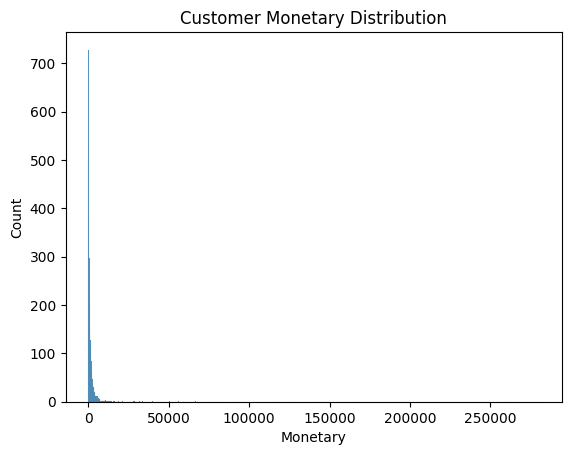

In [ ]:
# Monetary histogram plot
plt.title("Customer Monetary Distribution")
sns.histplot(monetary)
plt.show()

In [ ]:
monetary.sort_values(ascending=False).head()

,Monetary
CustomerID,
14646.0,280206.02
18102.0,259657.30
17450.0,194550.79
16446.0,168472.50
14911.0,143825.06


### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)#chaining method

country.head()

,CustomerID,Country_isUK
0,12346.0,UK
1,12347.0,Non UK
2,12348.0,Non UK
3,12349.0,Non UK
4,12350.0,Non UK


In [ ]:
# Merge the data
df_new = country.merge(recency, on = "CustomerID")\
                .merge(frequency, on = "CustomerID")\
                .merge(monetary, on = "CustomerID")

# Set CustomerID as index
df_new = df_new.set_index("CustomerID")
df_new.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non numeric variable
df_new = pd.get_dummies(df_new, columns=["Country_isUK"], drop_first=True, dtype=int)
df_new = df_new.rename(columns = {"Country_isUK_UK" : "Country_UK"})

df_new.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


### Scaling

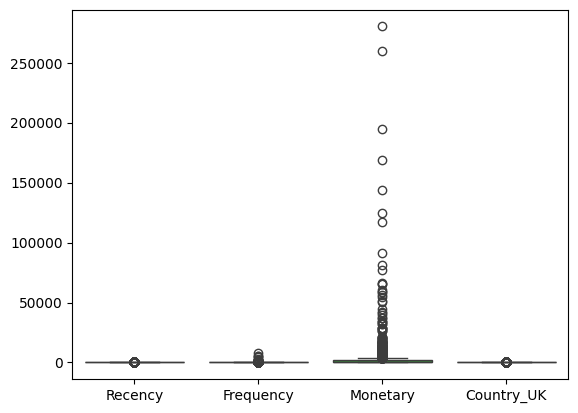

In [ ]:
sns.boxplot(data = df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


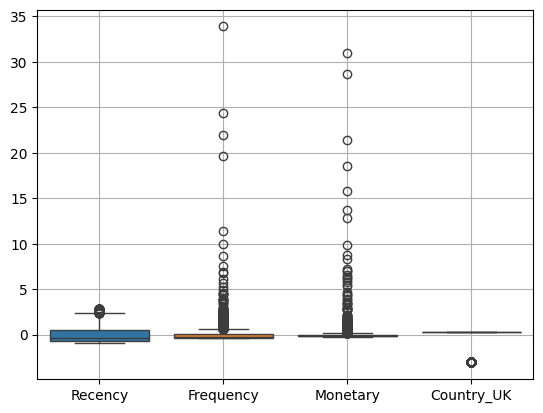

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

## Modeling

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))

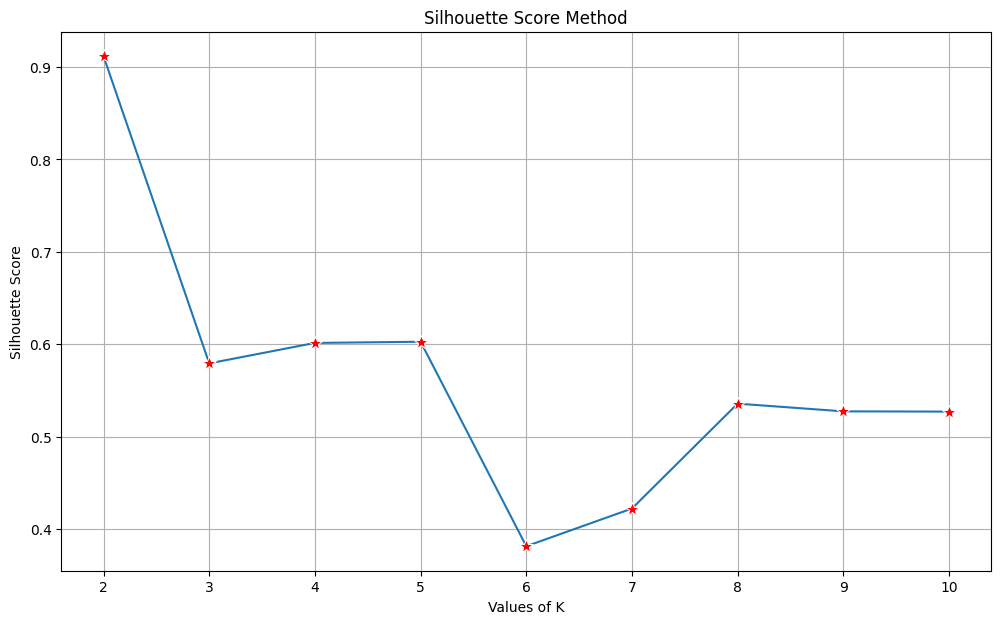

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is 2

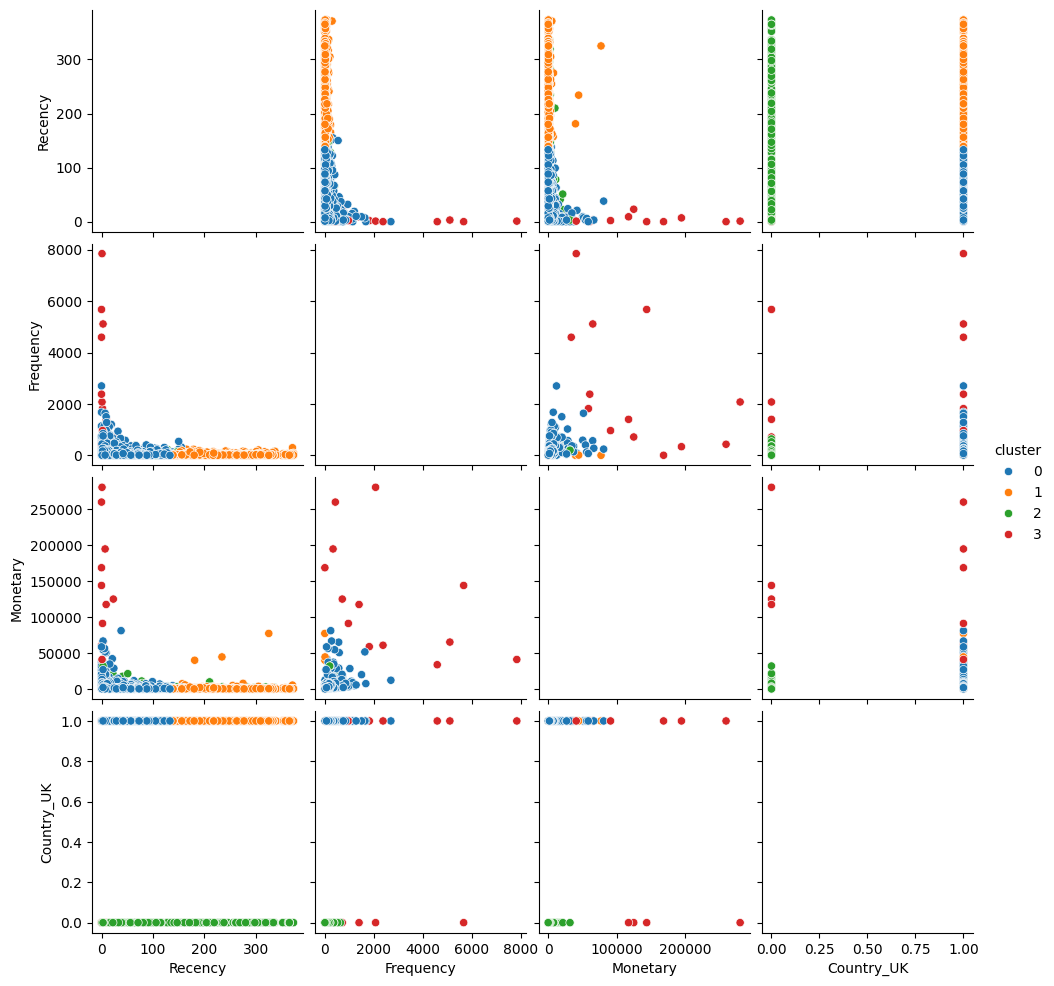

In [ ]:
#Pairplot
kmeans = KMeans(n_clusters=4,random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                      0             1             2              3
Recency   mean       39.950769    244.100406     95.405797       3.692308
          std        35.159384     66.874145    104.638705       6.459936
          min         0.000000    137.000000      0.000000       0.000000
          q25        11.000000    185.250000     18.000000       0.000000
          median     29.000000    239.000000     52.000000       1.000000
          q75        63.000000    294.750000    136.500000       3.000000
          max       155.000000    373.000000    373.000000      23.000000
Frequency mean      103.771624     27.692698     81.396135    2565.307692
          std       149.868026     32.084784     96.304061    2456.928617
          min         1.000000      1.000000      1.000000       3.000000
          q25        24.000000      8.250000     21.250000     714.000000
          median     56.000000     18.000000     45.000000    1818.000000
          q75       123.000000     33.000000    101.000000    4595.000000
          max      2700.000000    297.000000    638.000000    7847.000000
Monetary  mean     1959.378685    612.572121   2262.538913  126118.310000
          std      4359.621178   3141.707923   3479.689136   80607.677360
          min         6.200000      3.750000     51.560000   33719.730000
          q25       393.540000    163.575000    459.650000   60767.900000
          median    895.130000    305.955000   1025.700000  117379.630000
          q75      2005.630000    512.475000   2659.962500  168472.500000
          max     81024.840000  77183.600000  31906.820000  280206.020000

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        1             2925
1        1              986
2        0              414
3        0                4
         1                9
Name: Recency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Frequency"].count()

cluster  Country_UK
0        1             2925
1        1              986
2        0              414
3        0                4
         1                9
Name: Frequency, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

#Jawaban Question 1

## a) Top 5 Customer dengan Pembelian Terbanyak

In [ ]:
top_5_customers = df.groupby('CustomerID')['TotalAmount'].sum().sort_values(ascending=False).head(5)

print("Top 5 Customers dengan Pembelian Terbanyak:")
print(top_5_customers)

Top 5 Customers dengan Pembelian Terbanyak:
CustomerID
14646.0    280206.02
18102.0    259657.30
17450.0    194550.79
16446.0    168472.50
14911.0    143825.06
Name: TotalAmount, dtype: float64


## B). waktu pembelian dengan jumlah customer terbanyak

In [ ]:
df["Hour"] = df["InvoiceDate"].dt.hour
df["Day"] = df["InvoiceDate"].dt.day_name()
df["Month"] = df["InvoiceDate"].dt.month
df["Week"] = df["InvoiceDate"].dt.isocalendar().week

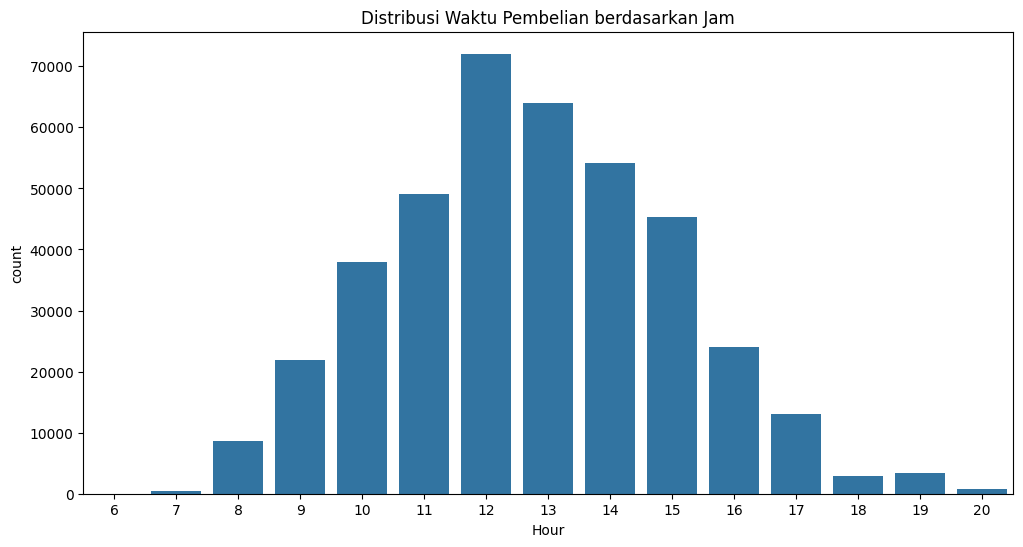

In [ ]:
# Visualisasi tentang Jam
plt.figure(figsize=(12, 6))
sns.countplot(x="Hour", data=df)
plt.title("Distribusi Waktu Pembelian berdasarkan Jam")
plt.show()

1. Insight pada grafik jam ini, menandakan rush hour transaction mencapai puncaknya pada pukul 12 siang, diikuti oleh pukul 13 siang. Ini menunjukkan bahwa banyak orang melakukan pembelian menjelang atau saat waktu istirahat siang.

2. Transaction terendah pada pukul 6 dan 7 pagi, dikarenakan dengan kesibukan pada pagi hari, lalu juga terendah pada pukul 20.00

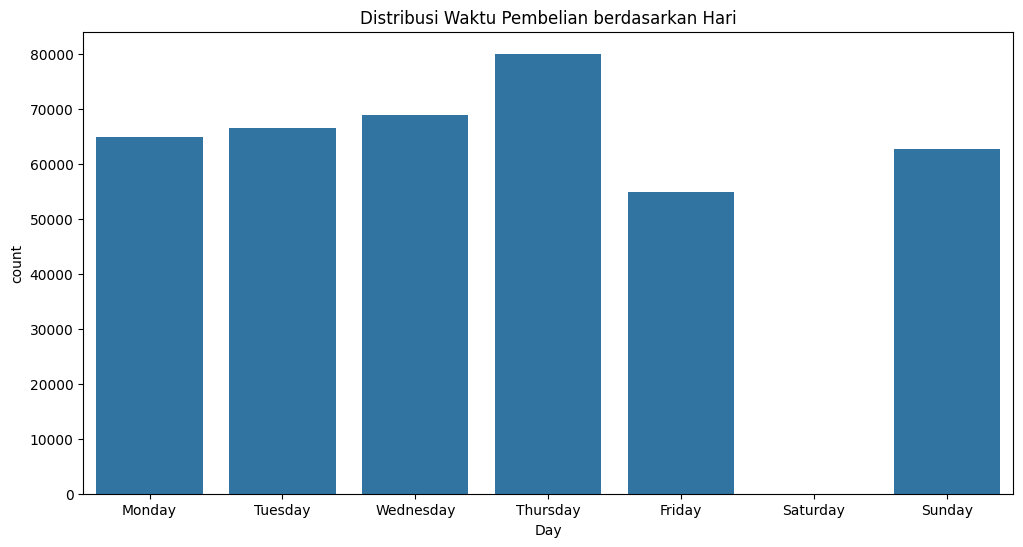

In [ ]:
# Visualisasi per Hari
plt.figure(figsize=(12, 6))
sns.countplot(x="Day", data=df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Distribusi Waktu Pembelian berdasarkan Hari")
plt.show()

1. Insight pembelian berdasarkan hari, menunjukkan kestabilan pada hari Senin-Rabu
2. Puncak pembelian terjadi  pada hari Kamis
3. Lalu mengalami penurunan pada hari Jumat-Minggu

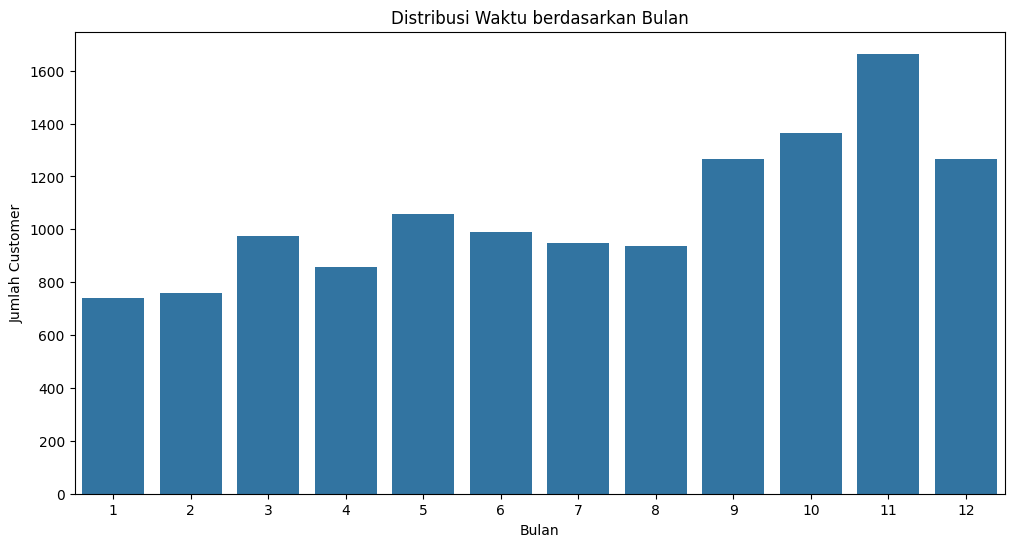

In [ ]:
# Visualisasi perbulan
df_monthly = df.groupby("Month")["CustomerID"].nunique().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x="Month", y="CustomerID", data=df_monthly)
plt.title("Distribusi Waktu berdasarkan Bulan")
plt.xlabel("Bulan")
plt.ylabel("Jumlah Customer")
plt.show()

1. Untuk jumlah transaction terbanyak pada Bulan September- November dikarenakan biasanya mendekati Natal dan juga Tahun Baru. Sehingga untuk pembelian dipersiapkan dari beberapa bulan sebelumnya. Dan terutama pada bulan November biasanya terdapat event besar-besaran.
2. Ada penurunan pada bulan Desember karena pada bulan ini sudah jarang ada pembelian dikarenakan sedang mempersiapkan kegiatan
3. Lalu pada bu

In [ ]:
top_products = df.groupby(["StockCode", "Description"])["Quantity"].sum().nlargest(5).reset_index()
top_products.columns = ["StockCode", "Description", "Total Quantity"]
print("Top 5 Produk dengan Penjualan Terbanyak:")
print(top_products)

Top 5 Produk dengan Penjualan Terbanyak:
  StockCode                         Description  Total Quantity
0     23843         PAPER CRAFT , LITTLE BIRDIE           80995
1     23166      MEDIUM CERAMIC TOP STORAGE JAR           77916
2     84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS           54415
3    85099B             JUMBO BAG RED RETROSPOT           46181
4    85123A  WHITE HANGING HEART T-LIGHT HOLDER           36725


#Jawaban Question 2


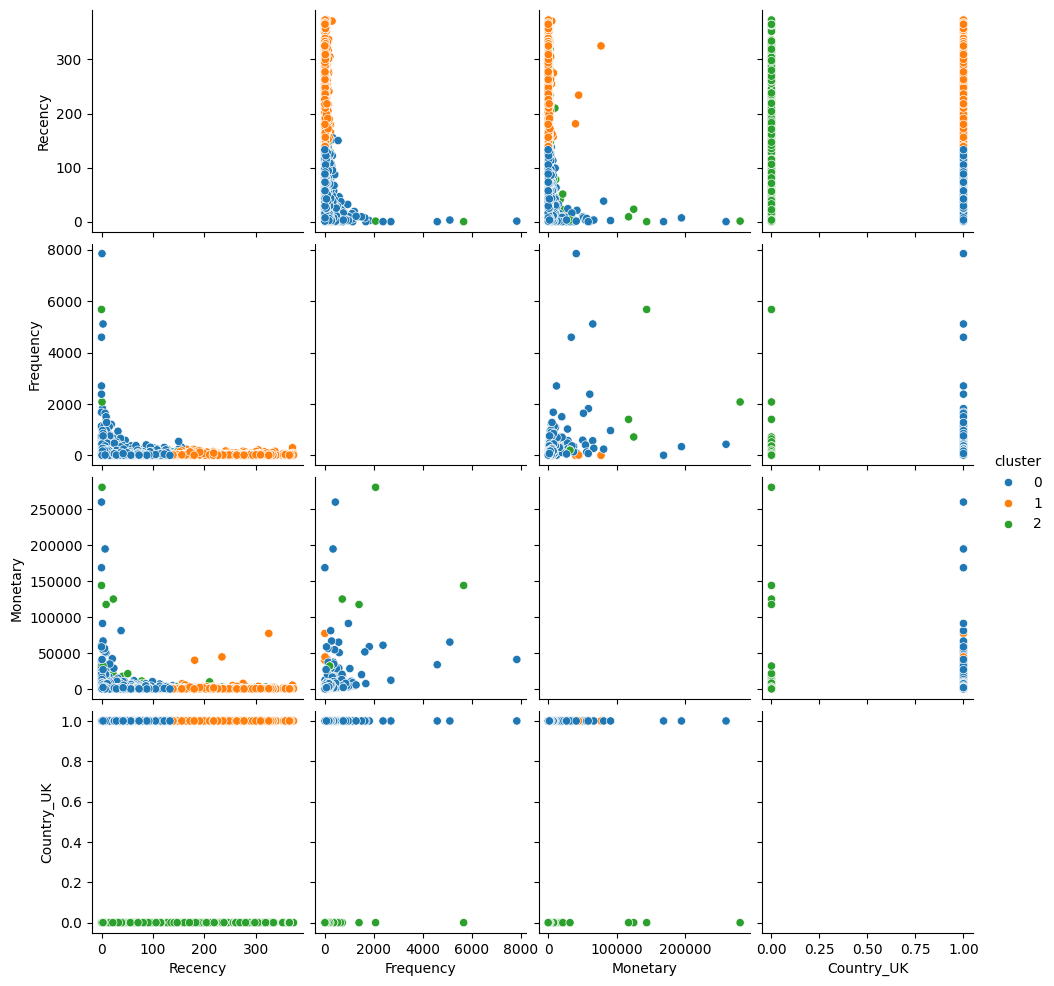

In [ ]:
# Karakteristik Cluster (3 Cluster)
kmeans = KMeans(n_clusters=3,random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)


In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                       0             1              2
Recency   mean        39.530598    243.142714      94.571770
          std         34.796185     67.322624     104.485451
          min          0.000000    135.000000       0.000000
          q25         11.000000    185.000000      18.000000
          median      29.000000    238.000000      51.000000
          q75         61.000000    294.000000     134.500000
          max        155.000000    373.000000     373.000000
Frequency mean       111.691966     27.760804     104.217703
          std        247.879197     32.138112     313.632715
          min          1.000000      1.000000       1.000000
          q25         24.000000      8.500000      22.000000
          median      57.000000     18.000000      45.000000
          q75        124.000000     33.000000     102.500000
          max       7847.000000    297.000000    5675.000000
Monetary  mean      2290.607659    611.421257    3834.967344
          std       8426.400177   3127.899451   17626.226186
          min          6.200000      3.750000      51.560000
          q25        396.480000    163.250000     460.522500
          median     903.900000    305.780000    1031.995000
          q75       2031.780000    511.250000    2705.637500
          max     259657.300000  77183.600000  280206.020000

Insight pada 3 cluster pada data diatas adalah:

1. Cluster 0 :

Recency: Rendah (rata-rata 32 hari)
Frequency: Tinggi (rata-rata 189 transaksi)
Monetary: Tinggi (rata-rata 7814)
Insight: Pelanggan pada cluster ini adalah pelanggan loyal dan aktif yang sering bertransaksi dan menghasilkan banyak pendapatan. Sebagian besar berasal dari UK.

2. Cluster 1

Recency: Tinggi (rata-rata 248 hari)
Frequency: Rendah (rata-rata 27 transaksi)
Monetary: Rendah (rata-rata 464)
Insight: Pelanggan pada cluster ini sudah lama tidak bertransaksi, jarang bertransaksi, dan menghasilkan sedikit pendapatan. Sebagian besar berasal dari luar UK.

3. Cluster 2

Recency: Sedang (rata-rata 76 hari)
Frequency: Sedang (rata-rata 76 transaksi)
Monetary: Sedang (rata-rata 1602)
Insight: Pelanggan pada cluster ini berada di tengah-tengah, tidak terlalu aktif tetapi juga tidak sepenuhnya churn. Sebagian besar berasal dari UK.

Promo yang sebaiknya dilakukan tiap Cluster

1. Cluster 0: Promo yang sebaiknya dilakukan yaitu dapat berupa reward, discount khususu untuk pembelian" selanjutnya. Sehingga dapat mempertahankan loyalitas dan meningkatkan nilai transaksi

2. Cluster 1 : Promo yang dapat diberikan ialah promo berupa gratis ongkir. Sehingga ada ketertarikan untuk dapat bertransaksi kembali.

3. Cluster 2 : Promo yang dapat diberikan yaitu penawaran membership, produk rekomendasi, paket bundling. Hingga dapat meningkatkan frekuensi dan nilai transaksi.

#Jawaban Question 3

In [ ]:
df_non_uk = df_new[df_new['Country_UK'] == 0].copy()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled_non_uk = scaler.fit_transform(df_non_uk.drop(columns=['Country_UK']))

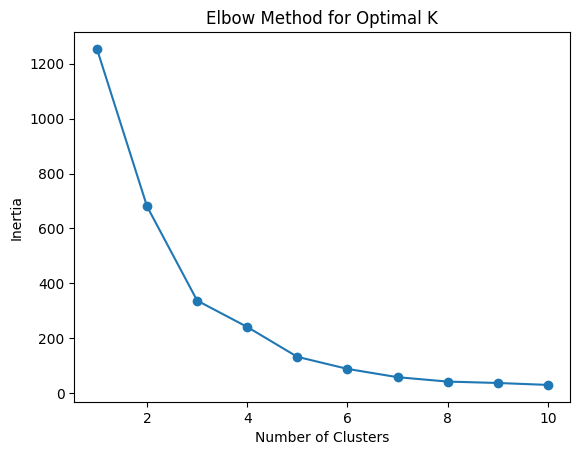

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled_non_uk)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_non_uk['cluster'] = kmeans.fit_predict(df_scaled_non_uk)

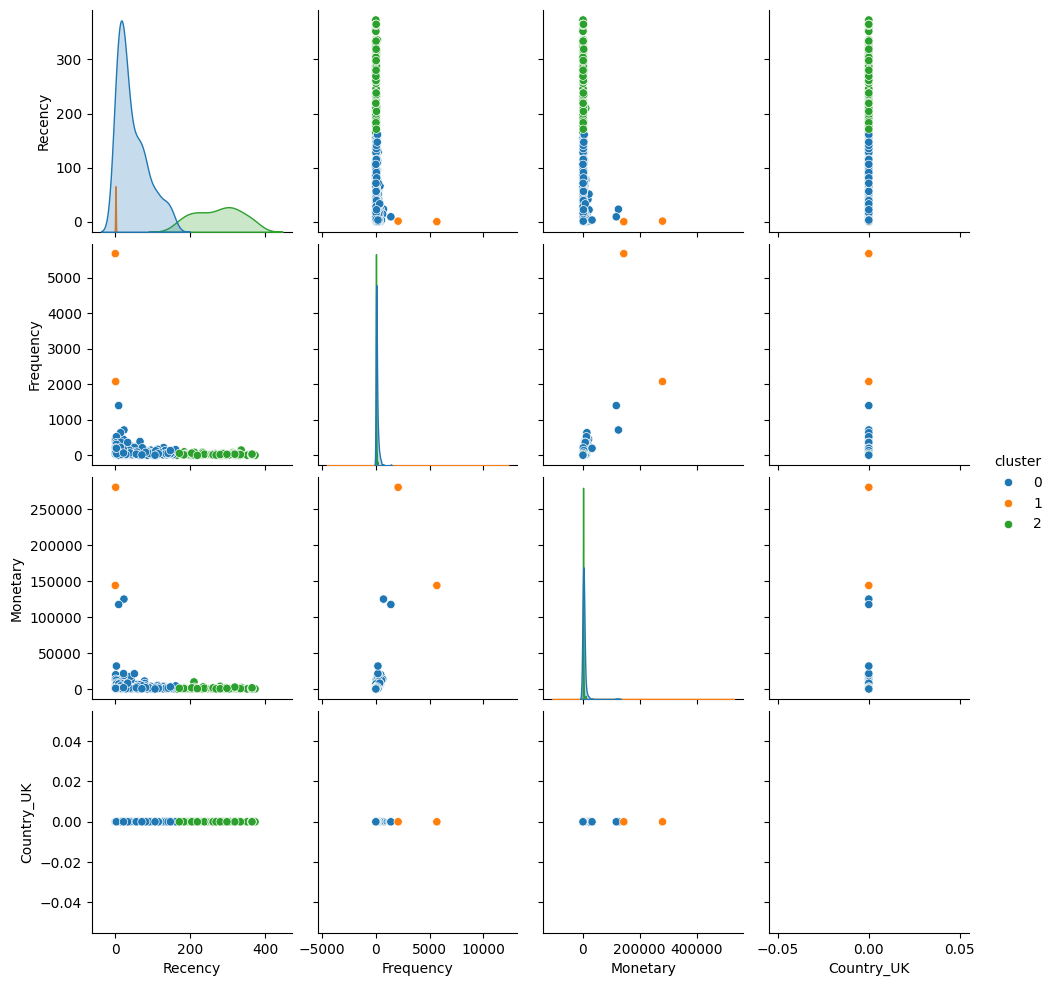

In [ ]:
import seaborn as sns

sns.pairplot(data=df_non_uk, hue='cluster', diag_kind='kde', palette='tab10')
plt.show()

Berdasarkan hasil output dari analisis di atas untuk cluster non UK

1. Cluster 0

  - Recency rendah: Baru transaksi
  - Frequency rendah: Jarang melakukan pembelian
  - Monetary rendah: Total nilai transaksi kecil
  - Peningkatan transaksi:
    1. Memberikan diskon agar pembeli melakukan kembali transaksi
    2. Menawarkan produk tambahan yang relvan berdasarkan pembelian
    3. Menawarkan bundling

2. Cluster 1

  - Recency tinggi : Sudah tidak bertransaksi dalam jangka yang lama
  - Frequency sangat tinggi : Pelanggan yang aktif dan masih berbelanja
  - Monetary Sangat tinggi : Melakukan jumlah pembelian (quantity) dengan sangat besar
  - Pelanggan di cluster ini hanya sedikit
  -Peningkatan strategi:
    1. Mengirim email khusus untuk penawaran ekslusif
    2. Mendapatkan akses ekslusif berupa diskon besar sebelum pelanggan reguler

3. Cluster 2
  -Recency bervariasi : Ada transaksi baru, dan ada transaksi yang sudah lama tidak bertransaksi
  - Frequency sedang: Pembelian lebih sering dibandingkan cluster 0
  - Monetary menengah : Nilai transaksi lebih tinggi dibandingkan cluster 0
  -Peningkatan transaksi:
    1. Pembuatan program membership untuk membuat pelanggan tetap loyal
    2. Retargeting Ads di media sosial untuk customer dapat pembelian berulang


**Kesimpulan**
1 . Cluster 0 (Low Engagement) : Fokus kepada etensi dan peningkatan engagement
2. Cluster 1 (High Value Customer) : Mencegah churn dengan personalized offers dan reaktivitas
3. Cluster 2 (Regular Customers): Buat pelanggan lebih loyal dengan reward & upselling

Berdasarkan hasil output dari analisis karakteristik utama dari masing-masing cluster non UK, berikut adalah beberapa kesimpulan yang dapat diambil:

*   List item
*   List item

*   List item
*   List item
